In [1]:
import os
os.chdir("../../")
print(os.getcwd())

d:\PhD_Projects\Mori-Zwanzig-Autoencoder


In [2]:
import torch, pickle, os
from torch.utils.data import Dataset, DataLoader
from src.PreProc_Data.DataProc import StackedSequenceDataset
import numpy as np
from src.Eval_MZA import Eval_MZA
import matplotlib.pyplot as plt
import pandas as pd
from Data.KS.KS_order import KS


In [3]:
torch.cuda.empty_cache()


exp_dir   = "G:/PhD_Imperial/PhD_Projects/MZA_Cluster_Models/KS/Exp6.2.4.3.2_L36_KS_testlargedata_nodropout_numobs"


# pickle.load(open("Trained_Models/Cluster_Models/Exp4.2.4_Transient_2DCyl_MULTISTEP_numobstest_with_seqmodel_switch/sl33_nhu40_numobs3_bs16_lr5e-5_ph10/args"))
models = []


exp_name_list = [
                 "sl49_nhu100_numobs12_bs512_lr5e-5_ph20",\
                 "sl49_nhu100_numobs16_bs512_lr5e-5_ph20",\
                 "sl49_nhu100_numobs20_bs512_lr5e-5_ph20",\
                 "sl49_nhu100_numobs24_bs512_lr5e-5_ph20",\
                #  "sl65_nhu40_numobs8_bs512_lr5e-5_ph20_2",\
                #  "sl129_nhu40_numobs8_bs512_lr5e-5_ph20_2"
                ]

# exp_name_list = [
#                  "sl9_nhu40_numobs6_bs512_lr5e-5_ph20",\
#                  "sl17_nhu40_numobs6_bs512_lr5e-5_ph20",\
#                  "sl25_nhu40_numobs6_bs512_lr5e-5_ph20",\
#                  "sl33_nhu40_numobs6_bs512_lr5e-5_ph20",\
#                  "sl49_nhu40_numobs6_bs512_lr5e-5_ph20",\
#                  "sl65_nhu40_numobs6_bs512_lr5e-5_ph20",\
#                  "sl129_nhu40_numobs6_bs512_lr5e-5_ph20",\
#                  "sl257_nhu40_numobs6_bs512_lr5e-5_ph20"
#                  ]

for exp_name in exp_name_list:#os.listdir(exp_dir):
    if exp_name != "results" and exp_name != ".DS_Store":
        print(exp_name)
        models.append(Eval_MZA(exp_dir, exp_name))
models
# eval_mza = Eval_MZA(exp_dir, exp_name)

lt = 50

sl49_nhu100_numobs12_bs512_lr5e-5_ph20
sl49_nhu100_numobs16_bs512_lr5e-5_ph20
sl49_nhu100_numobs20_bs512_lr5e-5_ph20
sl49_nhu100_numobs24_bs512_lr5e-5_ph20


In [4]:
print("Deactivate Model: ", models[0].deactivate_seqmodel)

Deactivate Model:  False


In [5]:
print("Pred horizon: ", models[0].pred_horizon)

Pred horizon:  20


Epoch with Minimum train_error:  2600


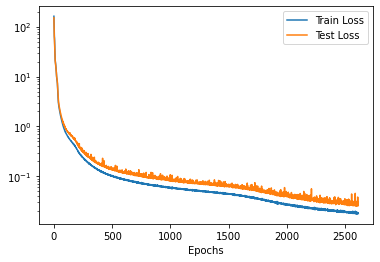

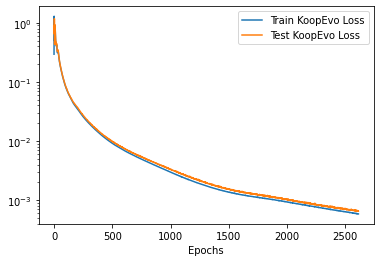

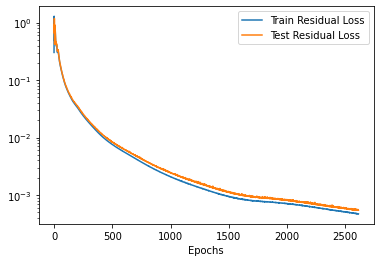

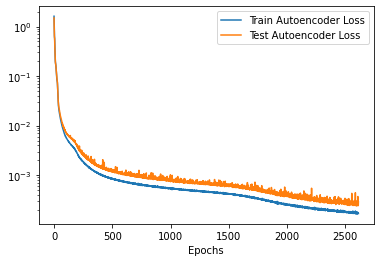

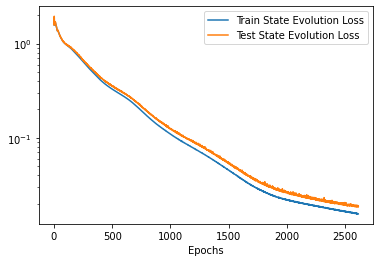

In [9]:
#plot learning curves
models[3].plot_learning_curves()

In [10]:
#for autoencoder_seq loading the strcuture separately for clarity and security
# for i in range(0,len(models)):
#     models[i].model.autoencoder = Autoencoder_seq(input_size = models[i].statedim, latent_size = models[i].num_obs, linear_ae = models[i].linear_autoencoder).to(models[0].device)

for i in range(0,len(models)):
    epoch_num = 7999
    models[i].load_weights(epoch_num, True)

In [11]:
# for i in range(0,len(models)):

ph0 = models[0].pred_horizon 
models[0].pred_horizon = 1

In [12]:

#One Step Prediction
model_num = 0
# models[model_num].data_dir = models[-2].data_dir
models[model_num].load_and_preproc_data()
models[model_num].create_dataset(mode = "Test")
dataset = models[model_num].test_dataset
num_trajs = models[model_num].test_num_trajs

# eval_mza.train_size = 0.9
for i in range(1):#len(models)):
    i=model_num
    # del eval_mza.lp_data 
    # torch.cuda.empty_cache()
    # del eval_mza.train_dataset
    # del eval_mza.train_dataloader
    if not models[i].deactivate_seqmodel:
        x_nn_hat, Phi_nn_hat, x_nn, Phi_nn, State_MSE, koop_out, seqmodel_out = models[i].predict_onestep(dataset, num_trajs)
    else:
        x_nn_hat, Phi_nn_hat, x_nn, Phi_nn, State_MSE = models[i].predict_onestep(dataset, num_trajs)
    print(x_nn_hat.shape, Phi_nn_hat.shape, Phi_nn.shape)

    #Plotting one step prediction
    x_nn_hat.shape

models[0].pred_horizon = ph0


Data Shape:  (1, 75000, 512)
Not normalizing Input
Test_Shape:  (1, 7500, 512)
Time:  0.6176793575286865


d:\Anaconda\envs\tf-gpu\lib\site-packages\torch\nn\modules\rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


torch.Size([1, 7499, 12]) torch.Size([1, 7499, 512]) torch.Size([1, 7499, 512])


In [13]:
Phi = models[0].test_data

Text(0, 0.5, 'MSE')

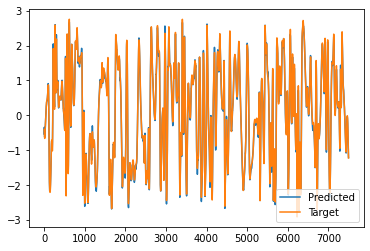

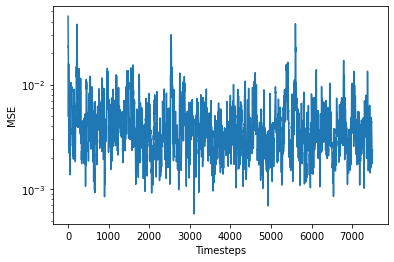

In [14]:
for i in range (1):
    plt.figure()
    plt.plot(Phi_nn_hat.cpu().numpy()[i,:,0], label = "Predicted")
    plt.plot(Phi_nn.cpu().numpy()[i,:,0], label = "Target")
    plt.legend()

plt.figure()
plt.semilogy(State_MSE.cpu().numpy())
plt.xlabel("Timesteps")
plt.ylabel("MSE")

Multi Step

In [15]:
for i in range(len(models)):
    models[i].deactivate_seqmodel = False

In [16]:
#multistep prediction
timesteps = 3000
initial_step = 0
initial_conditions = Phi_nn[:,initial_step,:].to(models[0].device)

x_ms_hat, xkoop_ms_hat, xseq_ms_hat = [], [], []
Phi_ms_hat = torch.zeros((len(models),1,timesteps+1,models[0].statedim)).to(models[0].device)
Phi_ms_koop = torch.zeros((len(models),1,timesteps,models[0].statedim)).to(models[0].device)

print("ic shape:", initial_conditions.shape)

for i in range(len(models)):
    x_hat_temp, Phi_ms_hat[i], Phi_ms_koop[i], xkoop_hat_temp, xseq_hat_temp = models[i].predict_multistep(initial_conditions, timesteps)
    x_ms_hat.append(x_hat_temp)
    xkoop_ms_hat.append(xkoop_hat_temp)
    xseq_ms_hat.append(xseq_hat_temp)
print(Phi_ms_hat.shape, Phi_ms_koop.shape)


ic shape: torch.Size([1, 512])
torch.Size([4, 1, 3001, 512]) torch.Size([4, 1, 3000, 512])


Text(0, 0.5, 'kinetic energy')

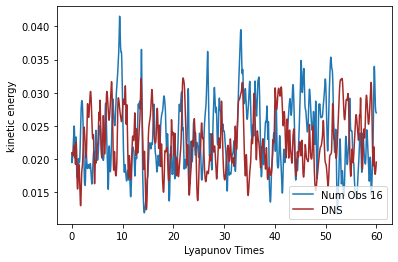

In [19]:
#kinetic energy of multistep rpediciton
def KS_kinetic_energy(Phi):
    L = 36
    k = 0.5*np.mean(Phi**2, axis = -1)/L
    return k

plt.figure()

timesteps_ke = 3000
lt = 50
x = np.arange(timesteps_ke)/lt

for i in [1]:
    
    plt.plot(x, KS_kinetic_energy(Phi_ms_hat[i,0,0:timesteps_ke].detach().cpu().numpy()), label = f"Num Obs {models[i].num_obs}")
    # else:
    #     plt.semilogy(State_MSE_multistep[len(models)-1].numpy(),".-",color = "brown", label = f"No Memory")
# State_MSE_multistep[1] = Eval_MZA.state_mse(Phi_nn[:,:timesteps],Phi_ms_hat[1,:,:timesteps]).detach().cpu()
# plt.semilogy(State_MSE_multistep[1].numpy(), label = f"Memory Length {models[1].seq_len}")
plt.plot(x[:], KS_kinetic_energy(Phi[0,initial_step:timesteps_ke+initial_step]), label = "DNS",color = "brown")

plt.legend(loc='lower right')
plt.xlabel("Lyapunov Times")
plt.ylabel("kinetic energy")

Text(0, 0.5, 'Probability Density')

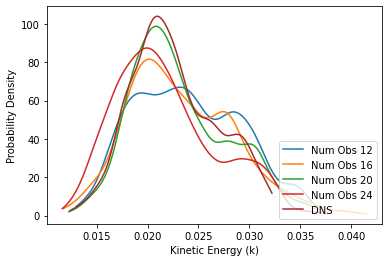

In [21]:
#pdf of kinteic energy

plt.figure()

for i in [0,1,2,3]:
    k, pdf = Eval_MZA.calc_pdf(KS_kinetic_energy(Phi_ms_hat[i,0,:].detach().cpu().numpy()))
    plt.plot(k,pdf , label = f"Num Obs {models[i].num_obs}")
    # else:
    #     plt.semilogy(State_MSE_multistep[len(models)-1].numpy(),".-",color = "brown", label = f"No Memory")
# State_MSE_multistep[1] = Eval_MZA.state_mse(Phi_nn[:,:timesteps],Phi_ms_hat[1,:,:timesteps]).detach().cpu()
# plt.semilogy(State_MSE_multistep[1].numpy(), label = f"Memory Length {models[1].seq_len}")
k, pdf = Eval_MZA.calc_pdf(KS_kinetic_energy(Phi[0,initial_step:timesteps+initial_step]))
plt.plot(k, pdf, label = "DNS",color = "brown")

plt.legend(loc='lower right')

plt.xlabel('Kinetic Energy (k)')
plt.ylabel('Probability Density')



[  0.           0.17453293   0.34906585   0.52359878   0.6981317
   0.87266463   1.04719755   1.22173048   1.3962634    1.57079633
   1.74532925   1.91986218   2.0943951    2.26892803   2.44346095
   2.61799388   2.7925268    2.96705973   3.14159265   3.31612558
   3.4906585    3.66519143   3.83972435   4.01425728   4.1887902
   4.36332313   4.53785606   4.71238898   4.88692191   5.06145483
   5.23598776   5.41052068   5.58505361   5.75958653   5.93411946
   6.10865238   6.28318531   6.45771823   6.63225116   6.80678408
   6.98131701   7.15584993   7.33038286   7.50491578   7.67944871
   7.85398163   8.02851456   8.20304748   8.37758041   8.55211333
   8.72664626   8.90117919   9.07571211   9.25024504   9.42477796
   9.59931089   9.77384381   9.94837674  10.12290966  10.29744259
  10.47197551  10.64650844  10.82104136  10.99557429  11.17010721
  11.34464014  11.51917306  11.69370599  11.86823891  12.04277184
  12.21730476  12.39183769  12.56637061  12.74090354  12.91543646
  13.0899693

Text(0, 0.5, 'kinetic energy')

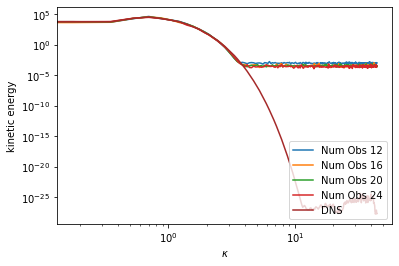

In [24]:
#energy spectrum
dt = 0.025
N  = 512
num_trajs = 1
max_n = int(8000/dt)
L = 36/(2*np.pi)#1/np.sqrt(0.085)
kse = KS(dt=dt, N=N, lambda2=1, L = L)

plt.figure()

timesteps_ke = 3000
lt = 50
x = np.arange(1000)/lt

Phi_ms_hat_fft = np.fft.rfft(Phi_ms_hat.detach().cpu().numpy())
k_fft = 0.5*np.mean(np.abs(Phi_ms_hat_fft)**2, axis = -2)
print(k_fft[0,0].shape)
for i in [0,1,2,3]:
    
    plt.loglog(kse.k[:-1], k_fft[i,0,:-1], label = f"Num Obs {models[i].num_obs}")
    # else:
    #     plt.semilogy(State_MSE_multistep[len(models)-1].numpy(),".-",color = "brown", label = f"No Memory")
# State_MSE_multistep[1] = Eval_MZA.state_mse(Phi_nn[:,:timesteps],Phi_ms_hat[1,:,:timesteps]).detach().cpu()
# plt.semilogy(State_MSE_multistep[1].numpy(), label = f"Memory Length {models[1].seq_len}")
Phi_fft = np.fft.rfft(Phi[0,initial_step:timesteps+initial_step], axis = -1)
print(Phi_fft.shape)
k_fft = 0.5*np.mean(np.abs(Phi_fft)**2, axis = 0)
plt.loglog(kse.k[:-1], k_fft[:-1], label = "DNS",color = "brown")

plt.legend(loc='lower right')
plt.xlabel(r"$\kappa$")
plt.ylabel("kinetic energy")



Text(0, 0.5, '$\\mathcal{K}(x_{2})$')

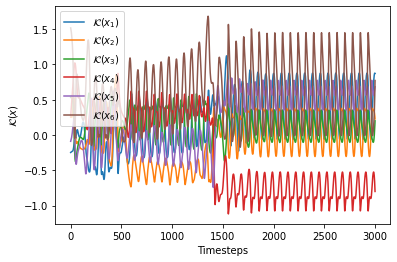

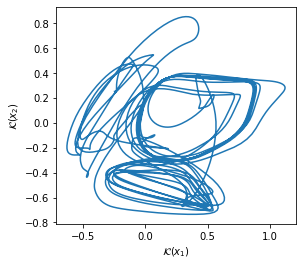

In [18]:
#plotting koopman mode evolution
plt.figure()
model_num = 2
for n in [0,1,2,3,4,5]:#range(models[model_num].num_obs):
    plt.plot(xkoop_ms_hat[model_num][0,:,n].cpu().numpy(), label = r"$\mathcal{K}$"+f"$(x_{n+1})$")
plt.legend()
plt.xlabel("Timesteps")
plt.ylabel(r"$\mathcal{K}(x)$")


plt.figure()
plt.gca().set_aspect('equal')
plt.plot(xkoop_ms_hat[model_num][0,:,0].cpu().numpy(), xkoop_ms_hat[model_num][0,:,1].cpu().numpy())

plt.xlabel(r"$\mathcal{K}(x_{1})$")
plt.ylabel(r"$\mathcal{K}(x_{2})$")

Text(0, 0.5, 'Observables $  L_{2} Norm$')

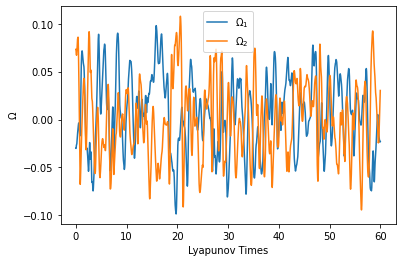

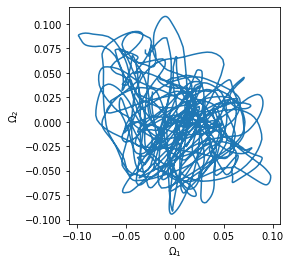

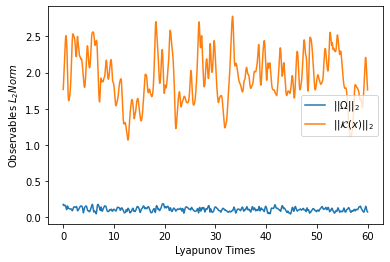

In [28]:
#plotting seqmodel mode evolution
plt.figure()
x = np.arange(timesteps)/lt

model_num = 1
tgt_xseq_ms_hat = xseq_ms_hat[model_num].cpu().numpy()
tgt_xkoop_ms_hat = xkoop_ms_hat[model_num].cpu().numpy()
for n in [0,1]:#range(models[model_num].num_obs):
    plt.plot(x, xseq_ms_hat[model_num][0,:,n].cpu().numpy(), label = r"$\Omega$"+f"$_{n+1}$")

plt.legend()
plt.xlabel("Lyapunov Times")
plt.ylabel(r"$\Omega$")

plt.figure()
plt.gca().set_aspect('equal')
plt.plot(xseq_ms_hat[model_num][0,:,0].cpu().numpy(), xseq_ms_hat[model_num][0,:,1].cpu().numpy())
plt.xlabel(f"$\Omega_{1}$")
plt.ylabel(f"$\Omega_{2}$")

plt.figure()
tgt_xseq_norm = np.linalg.norm(tgt_xseq_ms_hat, axis = -1)
tgt_xkoop_norm = np.linalg.norm(tgt_xkoop_ms_hat, axis = -1)


# plt.plot((tgt_xseq_norm/np.max(tgt_xseq_norm, axis = -1))[0,:], label = r"$||\Omega||_{2}$")
# plt.plot((tgt_xkoop_norm/np.max(tgt_xkoop_norm, axis = -1))[0,:], label = r"$||\mathcal{K}(x)||_{2}$")

plt.plot(x, (tgt_xseq_norm)[0,:], label = r"$||\Omega||_{2}$")
plt.plot(x, (tgt_xkoop_norm)[0,:], label = r"$||\mathcal{K}(x)||_{2}$")

plt.legend()
plt.xlabel("Lyapunov Times")
plt.ylabel("Observables " + r"$  L_{2} Norm$")

torch.Size([1, 7499, 512]) torch.Size([4, 1, 3001, 512])


Text(0, 0.5, 'MSE')

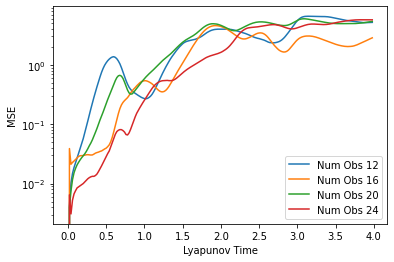

In [30]:
print(Phi_nn.shape, Phi_ms_hat.shape)
timesteps_mse = 200
State_MSE_multistep = torch.zeros((len(models),timesteps_mse))

x = np.arange(timesteps_mse)/lt
plt.figure()
for i in [0,1,2,3]:#range(len(models)-3):
    State_MSE_multistep[i] = Eval_MZA.state_mse(Phi_nn[:,:timesteps_mse],Phi_ms_hat[i,:,:timesteps_mse]).detach().cpu()
    # if i!=len(models)-1:
    
    plt.semilogy(x, State_MSE_multistep[i].numpy(), label = f"Num Obs {models[i].num_obs}")
    # else:
    #     plt.semilogy(State_MSE_multistep[len(models)-1].numpy(),".-",color = "brown", label = f"No Memory")

# State_MSE_multistep[1] = Eval_MZA.state_mse(Phi_nn[:,:timesteps],Phi_ms_hat[1,:,:timesteps]).detach().cpu()
# plt.semilogy(State_MSE_multistep[1].numpy(), label = f"Memory Length {models[1].seq_len}")
plt.legend()
plt.xlabel("Lyapunov Time")
plt.ylabel("MSE")
# np.save("koopman_numobs32.npy",Phi_hat.cpu().numpy())

In [ ]:
#calculating kinetic energy for multistep prediction
k_ms_pred = energy(U_ms_hat, V_ms_hat)
print(k_ms_pred.shape)
plt.figure()
for i in [0,1,2,3,4,5,6,7]:
    
    plt.plot(k_ms_pred[i,0,:], label = f"Number of Hidden Units {models[i].seq_len}")
    # else:
    #     plt.semilogy(State_MSE_multistep[len(models)-1].numpy(),".-",color = "brown", label = f"No Memory")
# State_MSE_multistep[1] = Eval_MZA.state_mse(Phi_nn[:,:timesteps],Phi_ms_hat[1,:,:timesteps]).detach().cpu()
# plt.semilogy(State_MSE_multistep[1].numpy(), label = f"Memory Length {models[1].seq_len}")
plt.plot(k[0,initial_step:], label = "DNS",color = "brown")

plt.legend(loc='lower right')
plt.xlabel("Timesteps")
plt.ylabel("kinetic energy")

Jacobian Analysis

In [31]:
#multistep prediction
timesteps_jac = 200
initial_step = 0
initial_conditions = Phi_nn[:,initial_step,:].to(models[0].device)

x_ms_hat, xkoop_ms_hat, xseq_ms_hat = [], [], []
Phi_ms_hat = torch.zeros((len(models),1,timesteps_jac+1,models[0].statedim)).to(models[0].device)
Phi_ms_koop = torch.zeros((len(models),1,timesteps_jac,models[0].statedim)).to(models[0].device)

print("ic shape:", initial_conditions.shape)

grad_xn_xseq = []

for i in [0,1,2,3]:#range(len(models)):
    
    grad_xn_xseq.append(models[i].jacobian_calc(initial_conditions, timesteps_jac))
    n = torch.mean(torch.norm(grad_xn_xseq[i].cpu(), dim = -1),dim = 1)
    print(i, n.shape)

print(grad_xn_xseq[0].shape)

ic shape: torch.Size([1, 512])


d:\Anaconda\envs\tf-gpu\lib\site-packages\torch\nn\modules\rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


0 torch.Size([1, 48])
1 torch.Size([1, 48])
2 torch.Size([1, 48])
3 torch.Size([1, 48])
torch.Size([1, 200, 48, 12])


torch.Size([200])
3 torch.Size([1, 48])
2 torch.Size([1, 48])
1 torch.Size([1, 48])
0 torch.Size([1, 48])


C:\Users\ASUS\AppData\Local\Temp\ipykernel_29520\1963813874.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([-tick for tick in plt.gca().get_xticks()])


Text(0.5, 0, 'Timesteps')

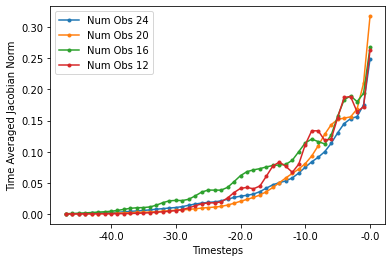

In [33]:
x = torch.arange(timesteps_jac)/lt
print(x[:].shape)
plt.figure()
for i in [3,2,1,0]:#range(len(models)):
    
    n = torch.mean(torch.norm(grad_xn_xseq[i].cpu(), dim = -1),dim = 1)
    print(i, n.shape)
    inv_n = torch.flip(n,[1])
    inv_x = torch.flip(x,[0])
    plt.plot( inv_n[0,:], ".-", label = f"Num Obs {models[i].num_obs}")
plt.legend()
plt.gca().invert_xaxis()
plt.gca().set_xticklabels([-tick for tick in plt.gca().get_xticks()])
plt.ylabel("Time Averaged Jacobian Norm")
plt.xlabel("Timesteps")

Eigenvalue Study

[1.000349  +0.j         0.9943956 +0.00410644j 0.9943956 -0.00410644j
 0.9706625 +0.j         0.92904574+0.0179496j  0.92904574-0.0179496j
 0.7584653 +0.j         0.2217573 +0.2545049j  0.2217573 -0.2545049j
 0.16302925+0.j        ]


Text(0, 0.5, '$Img(\\lambda)$')

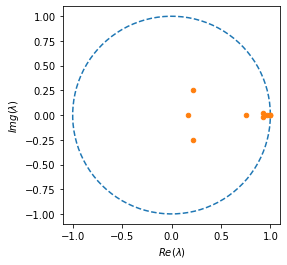

In [22]:
#eigenvalue study
plt.figure()
plt.gca().set_aspect('equal')

angles = np.linspace(0, 2 * np.pi, 100)
unit_circle = np.exp(1j * angles)
plt.plot(unit_circle.real, unit_circle.imag, '--', label = "Unit Circle")

for i in [3]:
    
    mat = models[i].model.koopman.getKoopmanMatrix()
    mat = mat.detach().cpu().numpy()
    w, v = np.linalg.eig(mat)

    idx = w.argsort()[::-1]
    w = w[idx]
    v = v[:,idx]

    print(w)
    # plt.matshow(mat)
    # plt.colorbar()
    # plt.figure()
    plt.plot(np.real(w), np.imag(w), ".", markersize = 9, label = f"Num Observables {models[i].num_obs}")

plt.xlabel(r"$Re(\lambda)$")
plt.ylabel(r"$Img(\lambda)$")
# plt.legend()

array([ 6.88992627e-03+0.02504206j,  6.88992627e-03-0.02504206j,
        1.19207514e-04+0.j        , -7.06891622e-03+0.j        ,
       -4.08650152e-02+0.04090352j, -4.08650152e-02-0.04090352j,
       -1.35614708e-01+0.j        , -5.64387262e-01+0.j        ,
       -7.99386919e-01+0.j        , -3.05544472e+00+0.j        ],
      dtype=complex64)

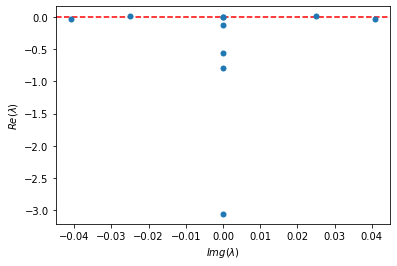

In [23]:
plt.figure()

plt.axhline(0, color='red', linestyle='--')

# plt.text(0.17, 0.075, 'x = 0.17', color='green')
for i in [0]:
    
    mat = models[i].model.koopman.getKoopmanMatrix()
    mat = mat.detach().cpu().numpy()
    w, v = np.linalg.eig(mat)

    idx = w.argsort()[::-1]
    w = w[idx]
    v = v[:,idx]

    lamb = (np.log(w)/0.25)
    plt.plot(np.imag(lamb[:]),np.real(lamb[:]),".", markersize = 10, label = f"Num Observables {models[i].num_obs}")

plt.ylabel(r"$Re(\lambda)$")
plt.xlabel(r"$Img(\lambda)$")

# plt.ylim(-0.1,0.1)
# plt.xlim(-1,1)
# plt.legend()
lamb

[[ 7.2499681e-01  1.4884576e-01 -1.2733236e-01 -2.7376369e-01
  -3.2968681e-02  3.4397909e-01  7.4303217e-02 -6.4007185e-02
  -2.8003680e-02  4.5552391e-01]
 [-4.1287165e-02  8.9542377e-01 -2.4513003e-01 -2.1997395e-01
   1.4958316e-01  1.8928923e-01  1.2582669e-01 -4.2336941e-02
   1.2620163e-02  9.2439890e-02]
 [-1.6348667e-01 -6.8173550e-02  4.6878937e-01 -2.8100458e-01
   3.3403617e-01  3.9833698e-01  1.7248723e-01 -5.6339115e-02
  -2.0049682e-01  1.3633522e-01]
 [ 1.1954852e-02 -9.3211658e-02 -7.9273991e-02  7.6126403e-01
   4.0217763e-01 -1.2370355e-01 -1.2330229e-01  9.5390588e-02
   1.6550983e-01 -2.2263603e-01]
 [-8.3087079e-02  5.8326207e-02 -1.5179381e-01 -2.1578149e-01
   7.9724658e-01  3.2704532e-01  1.4149848e-01 -9.2268653e-02
   2.6865043e-02  4.0279177e-01]
 [ 2.2350013e-01  2.6183233e-02  4.1888669e-01  3.3964604e-01
  -3.4302193e-01  6.1842823e-01 -1.5412647e-01  4.7644664e-02
   1.2186485e-01 -1.8504688e-01]
 [-5.2130032e-02 -2.5214890e-02 -1.8673681e-01 -1.9055639e

<Figure size 432x288 with 0 Axes>

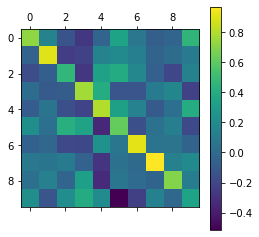

In [24]:
#Matrix
plt.figure()


for i in [3]:
    
    mat = models[i].model.koopman.getKoopmanMatrix()
    mat = mat.detach().cpu().numpy()
    plt.matshow(mat)
    plt.colorbar()
    # plt.figure()
    # plt.plot(np.real(w), np.imag(w), ".", label = f"Num Observables {models[i].num_obs}")
    print(mat)
# plt.legend()